In [11]:
import numpy as np
import pandas as pd
import gpflow as gpf
import os
import datetime
import dateutil
import pickle
import matplotlib.pyplot as plt
import sys

from dateutil import parser
from tqdm import trange

In [12]:
sys.path.append(sys.path[0][:-len('/data/wind')])  # for imports to work

In [13]:
sys.path

['/home/sebtsh/fast-drbo/data/wind',
 '/home/sebtsh/anaconda3/envs/fastdrbo/lib/python37.zip',
 '/home/sebtsh/anaconda3/envs/fastdrbo/lib/python3.7',
 '/home/sebtsh/anaconda3/envs/fastdrbo/lib/python3.7/lib-dynload',
 '',
 '/home/sebtsh/anaconda3/envs/fastdrbo/lib/python3.7/site-packages',
 '/home/sebtsh/anaconda3/envs/fastdrbo/lib/python3.7/site-packages/IPython/extensions',
 '/home/sebtsh/.ipython',
 '/home/sebtsh/fast-drbo/',
 '/home/sebtsh/fast-drbo',
 '/home/sebtsh/fast-drbo']

In [14]:
from core.utils import cross_product, construct_grid_1d
from metrics.plotting import plot_function_2d, plot_gp_2d

In [15]:
full_df = pd.read_csv("time_series_60min_singleindex.csv")

In [16]:
full_df.head()

,utc_timestamp,cet_cest_timestamp,AL_load_actual_entsoe_power_statistics,AT_load_actual_entsoe_power_statistics,AT_load_actual_entsoe_transparency,AT_load_forecast_entsoe_transparency,AT_price_day_ahead,AT_solar_generation_actual,AT_wind_onshore_generation_actual,BA_load_actual_entsoe_power_statistics,...,SK_load_forecast_entsoe_transparency,SK_solar_generation_actual,TR_load_actual_entsoe_power_statistics,UA_load_actual_entsoe_transparency,UA_load_forecast_entsoe_transparency,UA_east_load_actual_entsoe_transparency,UA_east_load_forecast_entsoe_transparency,UA_west_load_actual_entsoe_power_statistics,UA_west_load_actual_entsoe_transparency,UA_west_load_forecast_entsoe_transparency
0,2004-12-31T23:00:00Z,2005-01-01T00:00:00+0100,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2005-01-01T00:00:00Z,2005-01-01T01:00:00+0100,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2005-01-01T01:00:00Z,2005-01-01T02:00:00+0100,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2005-01-01T02:00:00Z,2005-01-01T03:00:00+0100,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2005-01-01T03:00:00Z,2005-01-01T04:00:00+0100,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [17]:
df = full_df[['utc_timestamp', 'DE_wind_generation_actual']].dropna().reset_index()

In [18]:
df

,index,utc_timestamp,DE_wind_generation_actual
0,43825,2010-01-01T00:00:00Z,3478.0
1,43826,2010-01-01T01:00:00Z,3414.0
2,43827,2010-01-01T02:00:00Z,3318.0
3,43828,2010-01-01T03:00:00Z,3058.0
4,43829,2010-01-01T04:00:00Z,3110.0
...,...,...,...
81753,125586,2019-04-30T17:00:00Z,7380.0
81754,125587,2019-04-30T18:00:00Z,7331.0
81755,125588,2019-04-30T19:00:00Z,8194.0
81756,125589,2019-04-30T20:00:00Z,8659.0


In [19]:
lol = parser.parse(df['utc_timestamp'][2]) - parser.parse(df['utc_timestamp'][0])

In [20]:
lol.seconds

7200

In [21]:
for i in trange(1, len(df)):
    if parser.parse(df['utc_timestamp'][i-1]).year == 2014 and parser.parse(df['utc_timestamp'][i]).year == 2015:
        print(i)
        break

 54%|██████████████████████████████████████████▎                                    | 43815/81757 [00:07<00:06, 5812.27it/s]

43816


In [22]:
start_index = 26300

In [23]:
end_index = 43816

In [24]:
reduced_df = df.loc[26300:43816].reset_index()

In [25]:
df.loc[:26300-1].describe()

,index,DE_wind_generation_actual
count,26300.000000,26300.000000
mean,56975.900760,4794.170228
std,7593.877043,4211.815622
min,43825.000000,92.000000
25%,50399.750000,1654.750000
50%,56974.500000,3494.500000
75%,63553.250000,6676.000000
max,70128.000000,24022.000000


In [26]:
reduced_df.describe()

,level_0,index,DE_wind_generation_actual
count,17517.000000,17517.000000,17517.000000
mean,35058.000000,78888.611691,5614.673688
std,5056.866668,5058.533581,5159.383033
min,26300.000000,70129.000000,29.000000
25%,30679.000000,74508.000000,1860.000000
50%,35058.000000,78887.000000,3954.000000
75%,39437.000000,83270.000000,7678.000000
max,43816.000000,87649.000000,29150.000000


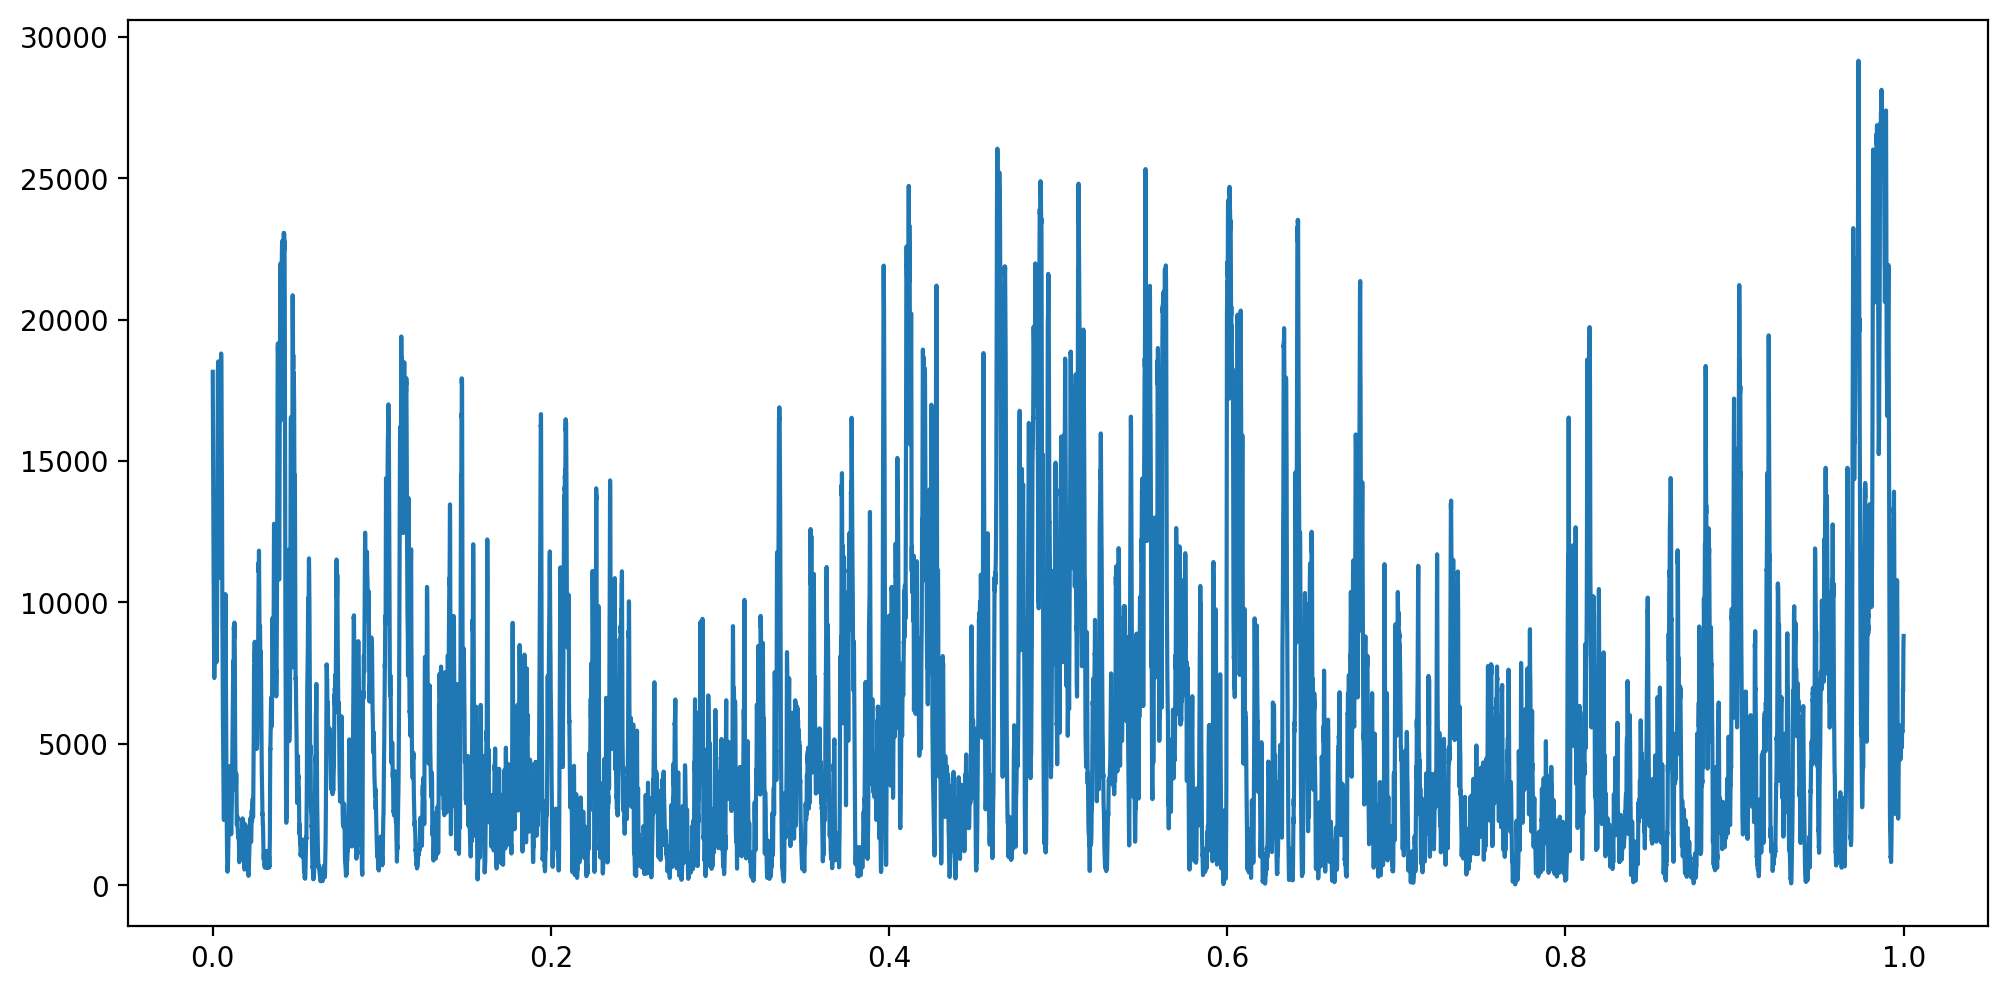

In [27]:
plt.figure(figsize=(12, 6), dpi=200)
plt.plot(np.linspace(0, 1, len(reduced_df)), reduced_df['DE_wind_generation_actual'])

In [28]:
years = [2013, 2014]
months = np.arange(1, 13)

In [35]:
boundary_indices = []
for i in trange(len(reduced_df) - 1):
    if parser.parse(reduced_df['utc_timestamp'][i]).month != parser.parse(reduced_df['utc_timestamp'][i+1]).month:
        boundary_indices.append(i)

100%|███████████████████████████████████████████████████████████████████████████████| 17516/17516 [00:05<00:00, 3328.40it/s]


In [38]:
len(boundary_indices)

24

In [39]:
boundary_indices = [0] + boundary_indices

In [40]:
boundary_indices

[0,
 743,
 1415,
 2159,
 2879,
 3623,
 4343,
 5087,
 5831,
 6551,
 7295,
 8015,
 8759,
 9503,
 10175,
 10915,
 11635,
 12379,
 13099,
 13843,
 14587,
 15307,
 16051,
 16771,
 17515]

In [41]:
for i in range(len(boundary_indices) - 1):
    print("i = {}".format(i))
    start, end = boundary_indices[i], boundary_indices[i+1]
    mean = reduced_df.loc[start:end]['DE_wind_generation_actual'].mean()
    std = reduced_df.loc[start:end]['DE_wind_generation_actual'].std()
    print("mean = {}, std = {}".format(mean, std))

i = 0
mean = 6744.788978494624, std = 6052.008849483418
i = 1
mean = 4773.98662704309, std = 4543.543432273081
i = 2
mean = 6291.81610738255, std = 5040.25913043077
i = 3
mean = 4612.393897364771, std = 3096.3483475012654
i = 4
mean = 3832.1879194630874, std = 2813.5992078249565
i = 5
mean = 4744.187239944522, std = 3645.3007991496943
i = 6
mean = 2302.1758389261745, std = 1812.687980598662
i = 7
mean = 3166.3691275167785, std = 2220.2020933545514
i = 8
mean = 4723.869625520111, std = 3503.6962541453595
i = 9
mean = 7368.575838926175, std = 5515.885973001743
i = 10
mean = 5994.646324549237, std = 4648.772040492217
i = 11
mean = 10011.789261744967, std = 7039.77875632868
i = 12
mean = 8375.53422818792, std = 5205.399600334529
i = 13
mean = 9132.320950965825, std = 5573.5069686486695
i = 14
mean = 6186.398110661268, std = 6335.198765579643
i = 15
mean = 4928.0679611650485, std = 4999.303944838208
i = 16
mean = 4974.18255033557, std = 3845.0469684711084
i = 17
mean = 3434.371705963939, st

In [42]:
reduced_df['DE_wind_generation_actual'] = reduced_df['DE_wind_generation_actual'] / reduced_df['DE_wind_generation_actual'].max()

In [43]:
reduced_df

,level_0,index,utc_timestamp,DE_wind_generation_actual
0,26300,70129,2013-01-01T00:00:00Z,0.622710
1,26301,70130,2013-01-01T01:00:00Z,0.591870
2,26302,70131,2013-01-01T02:00:00Z,0.549708
3,26303,70132,2013-01-01T03:00:00Z,0.520034
4,26304,70133,2013-01-01T04:00:00Z,0.487856
...,...,...,...,...
17512,43812,87645,2014-12-31T20:00:00Z,0.264322
17513,43813,87646,2014-12-31T21:00:00Z,0.281955
17514,43814,87647,2014-12-31T22:00:00Z,0.292830
17515,43815,87648,2014-12-31T23:00:00Z,0.296535


In [44]:
arr = reduced_df['DE_wind_generation_actual'].to_numpy()

(array([5.530e+02, 1.222e+03, 1.297e+03, 1.204e+03, 1.028e+03, 9.890e+02,
        9.710e+02, 8.470e+02, 8.520e+02, 7.100e+02, 6.430e+02, 5.490e+02,
        5.320e+02, 5.080e+02, 4.780e+02, 3.980e+02, 3.230e+02, 3.870e+02,
        2.960e+02, 2.860e+02, 3.090e+02, 2.410e+02, 2.390e+02, 2.150e+02,
        2.040e+02, 1.720e+02, 1.450e+02, 1.180e+02, 1.270e+02, 1.160e+02,
        9.500e+01, 1.120e+02, 1.000e+02, 6.500e+01, 8.000e+01, 7.800e+01,
        7.800e+01, 6.600e+01, 5.800e+01, 7.800e+01, 7.700e+01, 6.000e+01,
        6.500e+01, 4.600e+01, 3.600e+01, 4.300e+01, 4.400e+01, 4.900e+01,
        5.800e+01, 3.400e+01, 2.600e+01, 3.200e+01, 3.500e+01, 1.900e+01,
        2.500e+01, 1.900e+01, 9.000e+00, 1.100e+01, 1.900e+01, 2.000e+01,
        6.000e+00, 5.000e+00, 6.000e+00, 1.000e+00, 3.000e+00]),
 array([9.94854202e-04, 1.63641641e-02, 3.17334741e-02, 4.71027840e-02,
        6.24720939e-02, 7.78414039e-02, 9.32107138e-02, 1.08580024e-01,
        1.23949334e-01, 1.39318644e-01, 1.54687954e

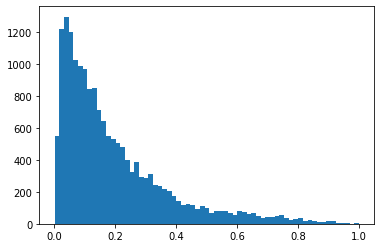

In [45]:
plt.hist(arr, bins='auto')

i = 0
mean = 0.2306421743014851, std = 0.2066327101907041


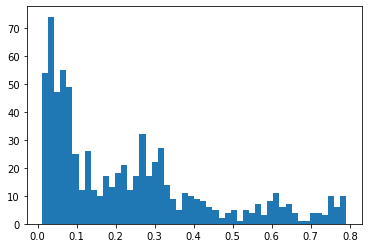

i = 1
mean = 0.16376128195703665, std = 0.15586739636186678


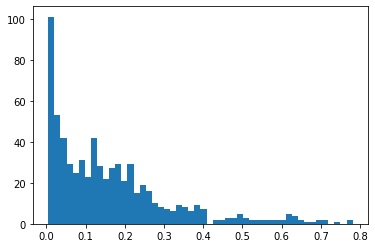

i = 2
mean = 0.2160455283203305, std = 0.1728190805651092


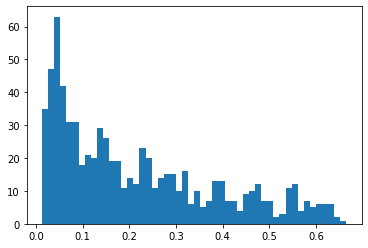

i = 3
mean = 0.15829716981132075, std = 0.106205732831441


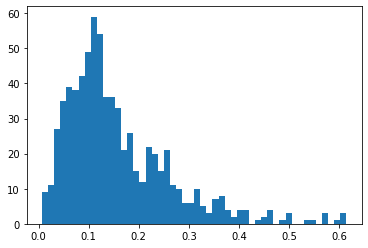

i = 4
mean = 0.13142141131337723, std = 0.09651427388114864


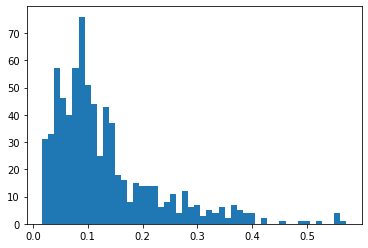

i = 5
mean = 0.16277315608919382, std = 0.1250517661257846


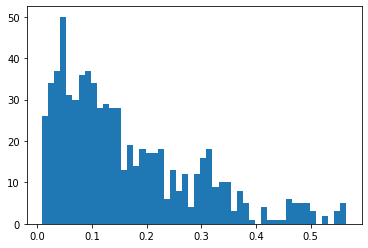

i = 6
mean = 0.0790023792397499, std = 0.06218093912931249


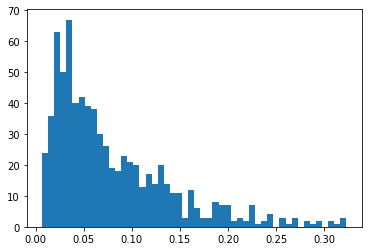

i = 7
mean = 0.10847848540179642, std = 0.07606210698162369


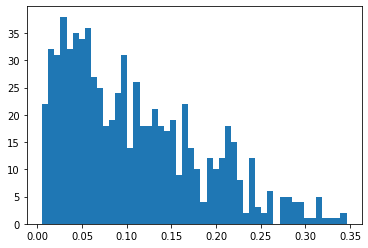

i = 8
mean = 0.161923908900324, std = 0.12014476190698059


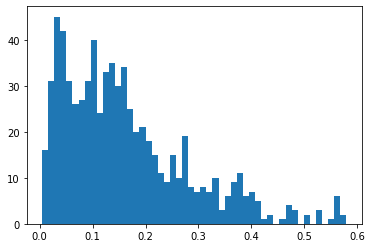

i = 9
mean = 0.25267438536306464, std = 0.18920170151203475


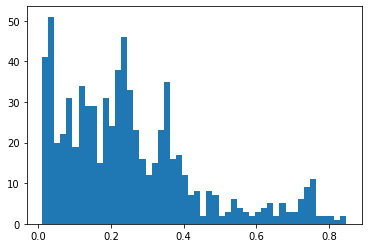

i = 10
mean = 0.20569334858014104, std = 0.15947300120934702


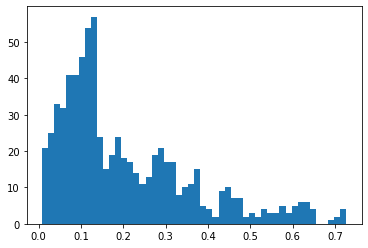

i = 11
mean = 0.3435271307106365, std = 0.24149438872992798


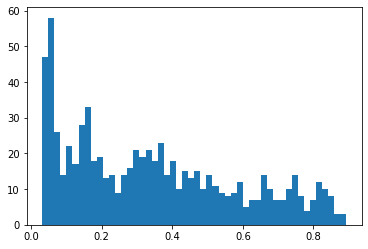

i = 12
mean = 0.2872466294103543, std = 0.17855995482117654


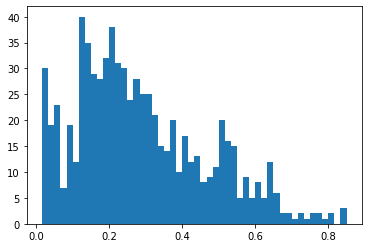

i = 13
mean = 0.3136631136159438, std = 0.19095202361863883


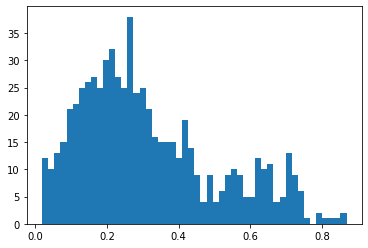

i = 14
mean = 0.21247299615224144, std = 0.21722727073823034


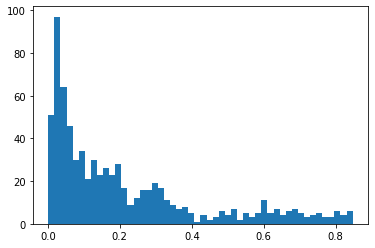

i = 15
mean = 0.16919820850009532, std = 0.17146193063024892


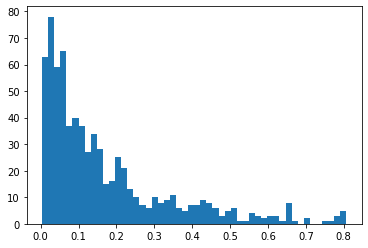

i = 16
mean = 0.1707464634168834, std = 0.13187408955978489


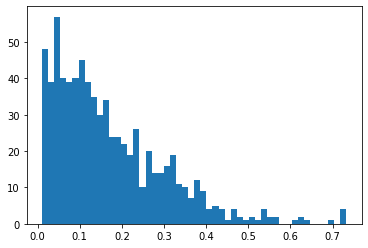

i = 17
mean = 0.11783766914427292, std = 0.0975353115295089


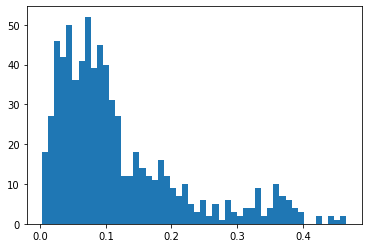

i = 18
mean = 0.10787417694904, std = 0.0667208444931438


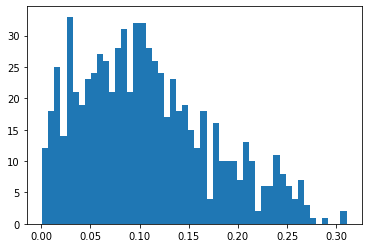

i = 19
mean = 0.15363797746177538, std = 0.13810129269514201


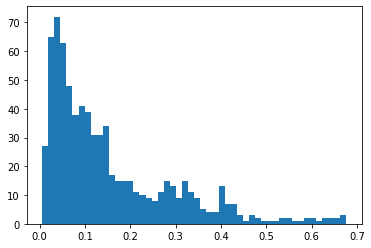

i = 20
mean = 0.11685687059271965, std = 0.09414613865811154


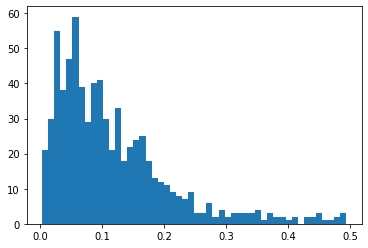

i = 21
mean = 0.1747964735609288, std = 0.15098998757984763


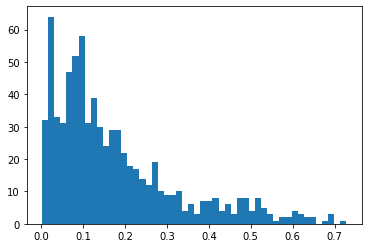

i = 22
mean = 0.18842938822184105, std = 0.1298617765515582


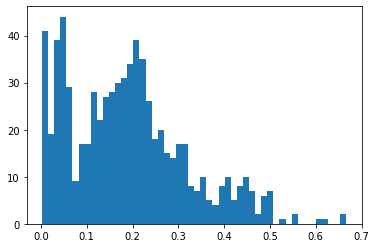

i = 23
mean = 0.396124928530589, std = 0.29389556668183


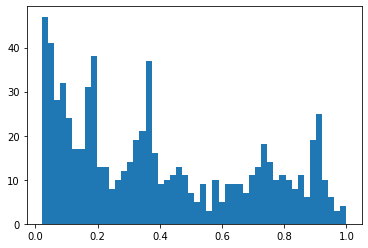

In [46]:
for i in range(len(boundary_indices) - 1):
    print("i = {}".format(i))
    start, end = boundary_indices[i], boundary_indices[i+1]
    data = arr[start:end]
    mean = np.mean(data)
    std = np.std(data)
    print("mean = {}, std = {}".format(mean, std))
    plt.hist(data, bins=50)
    plt.show()

Plan: 

Objective function: inventory cost function, follow Kirschner et. al. (2020)

action variable: 1D variable of predicting the power, 50 discrete

context variable: 1D variable of actual power generation, 50 discrete

reference distribution: Average distribution of 2010-2012

true distribution: actual power generation in a month within the range 2013-2014

margin: calculate the distance between reference and true and give to algorithms

average results over all 24 months between 2013 and 2014

In [47]:
action_density = 50
context_density = 50

In [63]:
action_points = construct_grid_1d(0, 1, action_density)

In [64]:
context_points = construct_grid_1d(0, 1, context_density)

In [65]:
search_points = cross_product(action_points, context_points)

Get reference distribution:

In [48]:
max_wind = df.loc[:43816]['DE_wind_generation_actual'].max()

In [49]:
ref_df = df.loc[:26300].reset_index()

In [50]:
ref_df['DE_wind_generation_actual'] = ref_df['DE_wind_generation_actual'] / max_wind

In [51]:
ref_df

,level_0,index,utc_timestamp,DE_wind_generation_actual
0,0,43825,2010-01-01T00:00:00Z,0.119314
1,1,43826,2010-01-01T01:00:00Z,0.117118
2,2,43827,2010-01-01T02:00:00Z,0.113825
3,3,43828,2010-01-01T03:00:00Z,0.104906
4,4,43829,2010-01-01T04:00:00Z,0.106690
...,...,...,...,...
26296,26296,70125,2012-12-31T20:00:00Z,0.621132
26297,26297,70126,2012-12-31T21:00:00Z,0.614511
26298,26298,70127,2012-12-31T22:00:00Z,0.621818
26299,26299,70128,2012-12-31T23:00:00Z,0.631012


In [52]:
ref_df.describe()

,level_0,index,DE_wind_generation_actual
count,26301.000000,26301.000000,26301.000000
mean,13150.000000,56976.400859,0.164483
std,7592.589051,7594.165770,0.144513
min,0.000000,43825.000000,0.003156
25%,6575.000000,50400.000000,0.056775
50%,13150.000000,56975.000000,0.119897
75%,19725.000000,63554.000000,0.229022
max,26300.000000,70129.000000,0.824082


In [53]:
ref_arr = ref_df['DE_wind_generation_actual'].to_numpy()

In [61]:
ref_arr

array([0.11931389, 0.11711835, 0.11382504, ..., 0.62181818, 0.63101201,
       0.62271012])

In [73]:
(context_points - ref_arr).shape

(50, 26301)

In [77]:
context_points[np.argmin(abs(context_points - ref_arr), axis=0)]

array([[0.12244898],
       [0.12244898],
       [0.12244898],
       ...,
       [0.6122449 ],
       [0.63265306],
       [0.63265306]])

In [78]:
ref_arr[:20]

array([0.11931389, 0.11711835, 0.11382504, 0.10490566, 0.10668954,
       0.09831904, 0.08689537, 0.08168096, 0.07571184, 0.06915952,
       0.06432247, 0.06284734, 0.05838765, 0.05962264, 0.05540309,
       0.05372213, 0.04939966, 0.04957118, 0.05090909, 0.04747856])

In [81]:
def discretize_1d(cont_values, context_points):
    """
    :param cont_values: shape (n)
    :param context_points: shape (m, 1)
    """
    return np.squeeze(context_points[np.argmin(abs(context_points - cont_values), axis=0)])

In [ ]:
discretized_ref_arr = discretize_1d(ref_arr, context_points)

In [ ]:
discretized_ref_arr

In [ ]:
unique, counts = np.unique(discretized_ref_arr, return_counts=True)

In [ ]:
def get_discrete_dist(arr, context_points):
    unique, counts = np.unique(arr, return_counts=True)
    dic = dict(zip(unique, counts))
    dist = np.zeros(len(context_points))
    for i in range(len(context_points)):
        ctx = context_points[i][0]
        if ctx in dic.keys():
            dist[i] = dic[ctx]
    return dist / len(arr)

In [ ]:
get_discrete_dist(discretized_ref_arr, context_points)

In [ ]:
counts

In [ ]:
plt.hist(ref_arr, bins=context_density)

In [ ]:
ref_dist = get_discrete_dist(discretized_ref_arr, context_points)

In [ ]:
power_in_months = []
true_dist_in_months = []
for i in range(len(boundary_indices) - 1):
    start, end = boundary_indices[i], boundary_indices[i+1] + 1
    data = discretize_1d(arr[start:end], context_points)
    power_in_months.append(data)
    
    true_dist_this_month = get_discrete_dist(data, context_points)
    true_dist_in_months.append(true_dist_this_month)

In [ ]:
power_in_months[0]

In [ ]:
true_dist_in_months[1]

In [ ]:
pickle.dump((ref_dist, power_in_months, true_dist_in_months),
           open("wind_data.p", "wb"))

In [90]:
search_points

In [91]:
discretized_ref_arr

array([0.12244898, 0.12244898, 0.12244898, ..., 0.6122449 , 0.63265306,
       0.63265306])

In [92]:
unique, counts = np.unique(discretized_ref_arr, return_counts=True)

In [106]:
def get_discrete_dist(arr, context_points):
    unique, counts = np.unique(arr, return_counts=True)
    dic = dict(zip(unique, counts))
    dist = np.zeros(len(context_points))
    for i in range(len(context_points)):
        ctx = context_points[i][0]
        if ctx in dic.keys():
            dist[i] = dic[ctx]
    return dist / len(arr)

In [109]:
get_discrete_dist(discretized_ref_arr, context_points)

array([0.01562678, 0.10528117, 0.10322801, 0.09166952, 0.08543401,
       0.07524429, 0.06265921, 0.05547318, 0.0478689 , 0.04307821,
       0.03802137, 0.03562602, 0.02969469, 0.02577849, 0.02300293,
       0.02102582, 0.01722368, 0.01608304, 0.01383978, 0.0128132 ,
       0.01056994, 0.01015171, 0.00870689, 0.00600738, 0.00577925,
       0.00566518, 0.00479069, 0.00475267, 0.00361203, 0.00326984,
       0.00395422, 0.00269952, 0.0028516 , 0.00216722, 0.00148283,
       0.00167294, 0.00125471, 0.00076043, 0.00060834, 0.00034219,
       0.00022813, 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ])

In [111]:
counts

array([ 411, 2769, 2715, 2411, 2247, 1979, 1648, 1459, 1259, 1133, 1000,
        937,  781,  678,  605,  553,  453,  423,  364,  337,  278,  267,
        229,  158,  152,  149,  126,  125,   95,   86,  104,   71,   75,
         57,   39,   44,   33,   20,   16,    9,    6])

(array([1587., 2368., 2109., 1944., 1807., 1695., 1509., 1286., 1188.,
        1046.,  967.,  876.,  771.,  749.,  672.,  560.,  497.,  483.,
         446.,  372.,  334.,  316.,  301.,  261.,  247.,  206.,  199.,
         166.,  127.,  127.,  114.,  113.,  110.,   93.,   78.,   71.,
          79.,   68.,   64.,   57.,   55.,   28.,   41.,   31.,   28.,
          15.,   12.,   15.,    7.,    6.]),
 array([0.00315609, 0.01957461, 0.03599314, 0.05241166, 0.06883019,
        0.08524871, 0.10166724, 0.11808576, 0.13450429, 0.15092281,
        0.16734134, 0.18375986, 0.20017839, 0.21659691, 0.23301544,
        0.24943396, 0.26585249, 0.28227101, 0.29868954, 0.31510806,
        0.33152659, 0.34794511, 0.36436364, 0.38078216, 0.39720069,
        0.41361921, 0.43003774, 0.44645626, 0.46287479, 0.47929331,
        0.49571184, 0.51213036, 0.52854889, 0.54496741, 0.56138593,
        0.57780446, 0.59422298, 0.61064151, 0.62706003, 0.64347856,
        0.65989708, 0.67631561, 0.69273413, 0.70915266, 

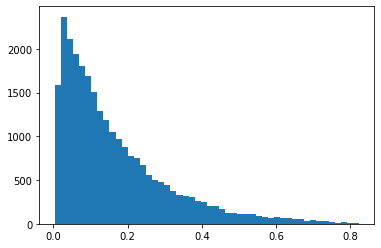

In [54]:
plt.hist(ref_arr, bins=context_density)

In [112]:
ref_dist = get_discrete_dist(discretized_ref_arr, context_points)

In [113]:
power_in_months = []
true_dist_in_months = []
for i in range(len(boundary_indices) - 1):
    start, end = boundary_indices[i], boundary_indices[i+1] + 1
    data = discretize_1d(arr[start:end], context_points)
    power_in_months.append(data)
    
    true_dist_this_month = get_discrete_dist(data, context_points)
    true_dist_in_months.append(true_dist_this_month)

In [114]:
power_in_months[0]

array([0.63265306, 0.59183673, 0.55102041, 0.51020408, 0.48979592,
       0.46938776, 0.44897959, 0.40816327, 0.40816327, 0.36734694,
       0.36734694, 0.32653061, 0.30612245, 0.30612245, 0.26530612,
       0.26530612, 0.24489796, 0.26530612, 0.26530612, 0.30612245,
       0.30612245, 0.30612245, 0.30612245, 0.30612245, 0.32653061,
       0.32653061, 0.32653061, 0.32653061, 0.32653061, 0.34693878,
       0.34693878, 0.34693878, 0.32653061, 0.32653061, 0.32653061,
       0.32653061, 0.30612245, 0.30612245, 0.28571429, 0.26530612,
       0.28571429, 0.30612245, 0.30612245, 0.30612245, 0.30612245,
       0.32653061, 0.34693878, 0.40816327, 0.44897959, 0.48979592,
       0.53061224, 0.59183673, 0.6122449 , 0.6122449 , 0.63265306,
       0.59183673, 0.6122449 , 0.6122449 , 0.63265306, 0.63265306,
       0.6122449 , 0.59183673, 0.57142857, 0.55102041, 0.55102041,
       0.53061224, 0.53061224, 0.48979592, 0.48979592, 0.44897959,
       0.44897959, 0.42857143, 0.42857143, 0.40816327, 0.38775

In [124]:
true_dist_in_months[1]

array([0.06835067, 0.13521545, 0.08469539, 0.0564636 , 0.05794948,
       0.04754829, 0.07875186, 0.04309064, 0.05052006, 0.0564636 ,
       0.04606241, 0.04309064, 0.03417533, 0.0282318 , 0.01634473,
       0.01188707, 0.01337296, 0.01931649, 0.01040119, 0.01931649,
       0.00445765, 0.00297177, 0.00445765, 0.00445765, 0.01040119,
       0.00445765, 0.00445765, 0.00445765, 0.00297177, 0.00297177,
       0.01040119, 0.00594354, 0.00297177, 0.00297177, 0.00297177,
       0.00297177, 0.00148588, 0.        , 0.00297177, 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ])

In [125]:
pickle.dump((ref_dist, power_in_months, true_dist_in_months),
           open("wind_data.p", "wb"))

In [14]:
search_points

array([[0.        , 0.        ],
       [0.        , 0.02040816],
       [0.        , 0.04081633],
       ...,
       [1.        , 0.95918367],
       [1.        , 0.97959184],
       [1.        , 1.        ]])

In [23]:
def wind_cost(action_contexts):
    """
    :param action_contexts: array of shape (n, 2)
    :return: tensor of shape (n, 1)
    """
    n, _ = action_contexts.shape
    
    c_minus_x = action_contexts[:, 1:] - action_contexts[:, 0:1]
    max_c_minus_x = np.max(np.concatenate([c_minus_x, np.zeros((n, 1))], axis=1), axis=1)[:, None]
    
    min_x_c = np.min(action_contexts, axis=1)[:, None]
    
    x_minus_c = action_contexts[:, 0:1] - action_contexts[:, 1:]
    max_x_minus_c = np.max(np.concatenate([x_minus_c, np.zeros((n, 1))], axis=1), axis=1)[:, None]
    
    return 0.1 * max_c_minus_x + min_x_c - 5 * max_x_minus_c

(<Figure size 432x288 with 2 Axes>, <AxesSubplot:>)

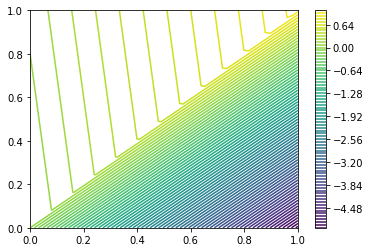

In [31]:
plot_function_2d(wind_cost, mins=[0, 0], maxs=[1, 1], grid_density=50, contour=True, colorbar=True)

In [35]:
k = gpf.kernels.SquaredExponential(lengthscales=0.1)

In [39]:
gp = gpf.models.GPR(data=(search_points, wind_cost(search_points)),
                   kernel=k)

In [40]:
gp.predict_f(search_points)

(<tf.Tensor: shape=(2500, 1), dtype=float64, numpy=
 array([[-0.04295893],
        [-0.0158817 ],
        [ 0.00948214],
        ...,
        [ 0.73918596],
        [ 0.78480636],
        [ 0.7948871 ]])>,
 <tf.Tensor: shape=(2500, 1), dtype=float64, numpy=
 array([[0.13803691],
        [0.10055705],
        [0.0832766 ],
        ...,
        [0.0832766 ],
        [0.10055705],
        [0.13803691]])>)

(<Figure size 432x288 with 2 Axes>,
 array([[<AxesSubplot:title={'center':'variance'}>]], dtype=object))

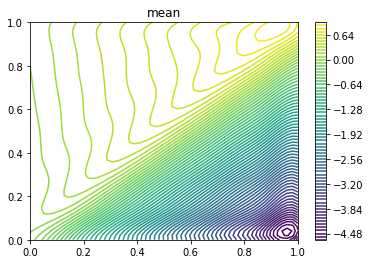

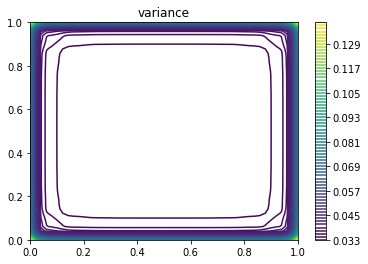

In [43]:
plot_gp_2d(gp, mins=[0,0], maxs=[1,1], grid_density=50)